# The freMTPL2freq dataset

Welcome to the glamorous world of motor insurance! In this workshop, you'll work with a real-world French motor third‑party liability dataset, a classic benchmark dataset for [claim frequency modeling](https://openacttexts.github.io/Loss-Data-Analytics/ChapFrequency-Modeling.html) (i.e., *how many claims do we expect per policy-year?*). The dataset comes from [CASdatasets](https://dutangc.github.io/CASdatasets/).

Each row corresponds to a single insurance policy exposure period, with the following columns:

- `IDpol`: The policy ID.
- `ClaimNb`: Number of claims during the exposure period.
- `Exposure`: The brand of the car, divided into unknown categories.
- `VehPower`: The power of the car (ordered values).
- `VehAge`: The vehicle age, in years
- `DrivAge`: The driver age, in years (in France, people can drive a car at 18)
- `BonusMalus`: Risk-based rating factor between 50 and 350 (threshold expected to be at 100).
- `VehBrand`: The car brand (unknown categories).
- `VehGas`: The car's fuel type (Diesel or Regular).
- `Area`: discretized (binned) version of population density (from "A" for rural area to "F" for urban centre).
- `Density`: The density of inhabitants (number of inhabitants per square-kilometer) of the city where the car driver lives in.
- `Region`: The policy region in France.

Below you'll find some possible starting points. Pick the level that best suits
you, dig in, or ignore them and do your own thing. Happy coding!


##### **Beginner**
- Start by getting oriented with `.head()`, `.info()`, `.describe()`.
    - How many rows/columns do you have?
    - Which columns are numeric vs categorical?
    - Are there missing values? If yes: where and how many?

- Sanity-check the basics:
    - What is total exposure in the dataset: `df["Exposure"].sum()`?
    - How many total claims: `df["ClaimNb"].sum()`?
    - What is the overall claim frequency (claims per year)?
    - Hint: a good baseline is `total_claims / total_exposure`.

- Claim counts are usually *very* skewed. Here are some questions you could answer:
    - Plot the distribution of `ClaimNb`.
    - What fraction of rows have `ClaimNb = 0`?
    - What's the maximum `ClaimNb`? Inspect a few of the largest-claim rows.

- Explore the categorical columns using `.value_counts()`:
    - `VehBrand`, `VehGas`, `Region`, `VehPower`  
    Which ones have many levels? Any very rare categories?

- Build your first "actuarial" summary table:
    - Compute claim rate (claim frequency per 1 unit exposure) by `VehGas` and by `Region`.
    - Important hint: don't average `ClaimNb / Exposure` row-by-row at first, instead compute `sum(ClaimNb) / sum(Exposure)` within each group.



##### **Intermediate**
-  Try out creating a rate column, which would be the claim frequency per 1 unit exposure:
    - Define `ClaimFreq = ClaimNb / Exposure`
    - Before you do: check if any `Exposure` is 0 or extremely small. What would that do to `ClaimFreq`?

- Make risk buckets (this dataset loves buckets) using [`pd.cut()`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html):
    - Bin `DrivAge` into age groups (e.g. 18-25, 26-35, etc.)
    - Bin `VehAge` into "new-ish" vs "old-ish" (or more bins).

- Build a mini "pricing table":
    - For each of these, compute `sum(ClaimNb) / sum(Exposure)` and rank groups:
        - `Region`
        - `VehPower`
        - `VehBrand` (any rare brands?)
        - combinations like `(Region, VehGas)` or `(DrivAgeGroup, VehPower)`

- Bonus/malus is meant to be informative, lets test that it is:
    - Plot claim rate as a function of `BonusMalus` (bin it if it has many unique values).
    - Is the relationship monotone? Are there weird plateaus or jumps?

- Visual storytelling ideas:
    - A heatmap of claim rates for `(DrivAgeGroup x VehPower)` or `(Region x VehGas)`.
    - A "risk profile" plot: predicted/observed claim rate vs driver age group.


##### **Advanced**
- Try out building a proper frequency model (the canonical approach):
    - Split into train/test (or use cross-validation).
    - Fit a [Poisson GLM](https://en.wikipedia.org/wiki/Poisson_regression) with a log link and `Exposure` as an *offset*:
        - Model `ClaimNb ~ features + offset(log(Exposure))`
        - If you use `statsmodels`, look into [`GLM`](https://www.statsmodels.org/stable/glm.html).

- Perhaps the claim frequency is not actually Poisson distributed here? A common problem is "overdispersion", i.e. that `Var(ClaimNb)` is much larger than `Mean(ClaimNb)`. Does this hold in our data, and does this contradict the Poisson distribution? You might compare Poisson vs [Negative Binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) (and see if it helps in the modeling).

- Another idea is to go nonlinear:
    - Fit a tree/boosting model with a Poisson objective (e.g. [XGBoost](https://xgboost.readthedocs.io/en/stable/), [LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html), or [CatBoost](https://catboost.ai/docs/en/concepts/python-quickstart)).
    - Handle categoricals carefully (one-hot, target encoding, or a model that natively supports categoricals).
    - Don't forget exposure: use it as an offset (if supported) or as weights + careful target definition.

- Interpretability (because "why does the model think that?"):
    - For GLMs: interpret coefficients (and check multicollinearity).
    - For boosting: try [SHAP](https://shap.readthedocs.io/en/latest/) and inspect whether effects make sense (e.g., BonusMalus, age, density).
    - Cutting edge: try out the [Explainable Boosting Machine (EBM)](https://interpret.ml/docs/ebm.html), which is a boosting method known to give performance at par with SOTA boosting methods while remaining interpretable.

In [16]:
import pandas as pd

df = pd.read_csv('freMTPL2freq.csv')

# Fler rader: om du har ytterligare en CSV med samma kolumner, slå ihop:
# df_extra = pd.read_csv('sökväg/till/annan_fil.csv')
# df = pd.concat([df, df_extra], ignore_index=True)

df.head()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
0,1.0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
1,3.0,1,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes
2,5.0,1,0.75,6,2,52,50,B12,Diesel,B,54,Picardie
3,10.0,1,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine
4,11.0,1,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine


In [17]:
df.dtypes

IDpol         float64
ClaimNb         int64
Exposure      float64
VehPower        int64
VehAge          int64
DrivAge         int64
BonusMalus      int64
VehBrand       object
VehGas         object
Area           object
Density         int64
Region         object
dtype: object

In [18]:
# 2. Lista numeriska kolumner (int, float)
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
print('Numeriska kolumner:', numeric_cols)

# 3. Lista text-/kategorikolumner (object, string)
text_cols = df.select_dtypes(include=['object']).columns.tolist()
print('Text-/kategorikolumner:', text_cols)

Numeriska kolumner: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']
Text-/kategorikolumner: ['VehBrand', 'VehGas', 'Area', 'Region']


In [19]:
# 1. Antal saknade per kolumn
df.isna().sum()

# 2. Andel saknade per kolumn (i %)
#(df.isna().sum() / len(df) * 100).round(2)

# 3. Totalt antal saknade i hela datan
#df.isna().sum().sum()

# 4. Visa rader som har minst ett saknat värde
#df[df.isna().any(axis=1)]

IDpol         0
ClaimNb       0
Exposure      0
VehPower      0
VehAge        0
DrivAge       0
BonusMalus    0
VehBrand      0
VehGas        0
Area          0
Density       0
Region        0
dtype: int64

In [20]:
df['Exposure'].sum()


np.float64(358499.44546217704)

In [21]:
df['ClaimNb'].sum()

np.int64(36102)

(0.0, 1.0)

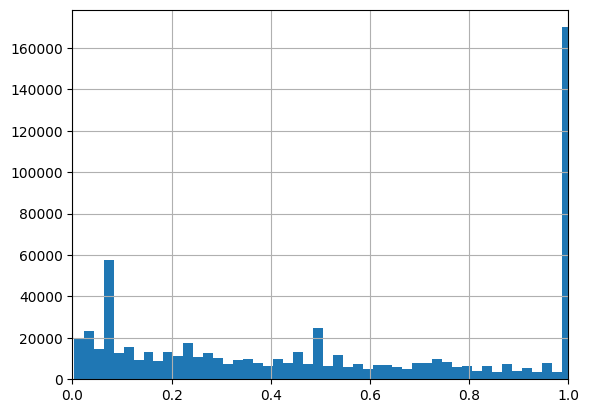

In [22]:
ax = df['Exposure'].hist(bins=100)
ax.set_xlim(0, 1)

In [36]:
df.describe()

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density
count,6.780130e+05,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000
mean,2.621857e+06,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405
std,1.641783e+06,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564
min,1.000000e+00,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000
25%,1.157951e+06,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000
50%,2.272152e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000
75%,4.046274e+06,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000
max,6.114330e+06,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000


In [37]:
df['ClaimNb'].describe()

count    678013.000000
mean          0.053247
std           0.240117
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          16.000000
Name: ClaimNb, dtype: float64

In [38]:
df[df['ClaimNb'] > 5]

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region
6539,19471.0,11,1.00,5,6,65,50,B2,Diesel,A,13,Centre
304484,2216294.0,6,0.33,4,12,52,50,B1,Regular,D,824,Languedoc-Roussillon
320764,2239279.0,8,0.41,4,12,52,50,B1,Regular,D,824,Languedoc-Roussillon
321248,2241683.0,16,0.33,4,12,52,50,B1,Regular,D,824,Languedoc-Roussillon
321512,2248174.0,9,0.08,4,12,52,50,B1,Regular,D,824,Languedoc-Roussillon
487268,3253234.0,11,0.08,4,13,53,50,B1,Regular,D,824,Languedoc-Roussillon
488270,3254353.0,11,0.07,4,13,53,50,B1,Regular,D,824,Languedoc-Roussillon


In [45]:
df[['VehPower', 'DrivAge']].corr()

,VehPower,DrivAge
VehPower,1.000000,0.030108
DrivAge,0.030108,1.000000


In [51]:
# Per VehGas
df.groupby('VehGas').agg(ClaimNb=('ClaimNb', 'sum'), Exposure=('Exposure', 'sum'))
# Sedan: total_claims / total_exposure per grupp
t = df.groupby('VehGas').agg(ClaimNb=('ClaimNb', 'sum'), Exposure=('Exposure', 'sum'))
t['ClaimRate'] = t['ClaimNb'] / t['Exposure']
t['ClaimRate']

# Per Region
t2 = df.groupby('Region').agg(ClaimNb=('ClaimNb', 'sum'), Exposure=('Exposure', 'sum'))
t2['ClaimRate'] = t2['ClaimNb'] / t2['Exposure']
t2['ClaimRate']

Region
Alsace                         0.109998
Aquitaine                      0.094120
Auvergne                       0.081364
Basse-Normandie                0.095075
Bourgogne                      0.101684
Bretagne                       0.097357
Centre                         0.089609
Champagne-Ardenne              0.132689
Corse                          0.139869
Franche-Comte                  0.101062
Haute-Normandie                0.095353
Ile-de-France                  0.131684
Languedoc-Roussillon           0.104980
Limousin                       0.108097
Midi-Pyrenees                  0.098004
Nord-Pas-de-Calais             0.091119
Pays-de-la-Loire               0.091638
Picardie                       0.122817
Poitou-Charentes               0.086712
Provence-Alpes-Cotes-D'Azur    0.109164
Rhone-Alpes                    0.110966
Name: ClaimRate, dtype: float64

## Poisson XGBoost (claim frequency)

XGBoost med Poisson-mål, one-hot av kategorier, Exposure som offset. På Mac: brew install libomp (en gång).

In [58]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [75]:
import numpy as np
from sklearn.model_selection import train_test_split

import xgboost as xgb

# Feature engineering: åldersgrupper
df_ = df.copy()
df_['DrivAgeGroup'] = pd.cut(df_['DrivAge'], bins=[17, 25, 35, 45, 55, 65, 100], labels=False).astype(float).fillna(0)
df_['VehAgeGroup'] = pd.cut(df_['VehAge'], bins=[-1, 0, 5, 10, 50], labels=False).astype(float).fillna(0)

# Stratifierad split (samma andel 0/1+ skador i train och test)
strat = (df_['ClaimNb'] >= 1).astype(int)
train_idx, test_idx = train_test_split(df_.index, test_size=0.1, random_state=42, stratify=strat)
train_df = df_.loc[train_idx].copy()
test_df = df_.loc[test_idx].copy()

# Target encoding med smoothing (endast på train)
global_rate = train_df['ClaimNb'].sum() / train_df['Exposure'].sum()
smooth = 100
def target_encode(df_fit, df_apply, col):
    agg = df_fit.groupby(col).apply(lambda g: (g['ClaimNb'].sum() + global_rate * smooth) / (g['Exposure'].sum() + smooth), include_groups=False)
    return df_apply[col].map(agg).fillna(global_rate).values

train_df['Region_rate'] = target_encode(train_df, train_df, 'Region')
test_df['Region_rate'] = target_encode(train_df, test_df, 'Region')
train_df['VehBrand_rate'] = target_encode(train_df, train_df, 'VehBrand')
test_df['VehBrand_rate'] = target_encode(train_df, test_df, 'VehBrand')
train_df['Area_rate'] = target_encode(train_df, train_df, 'Area')
test_df['Area_rate'] = target_encode(train_df, test_df, 'Area')

# Log-Density och Density-grupp (rural / mellan / urban)
train_df['log_Density'] = np.log1p(train_df['Density'])
test_df['log_Density'] = np.log1p(test_df['Density'])
density_bins = [0, 4, 7, 15]
train_df['DensityGroup'] = np.digitize(train_df['log_Density'], density_bins).clip(0, len(density_bins)).astype(float)
test_df['DensityGroup'] = np.digitize(test_df['log_Density'], density_bins).clip(0, len(density_bins)).astype(float)

# Numeriska + target-encodade + one-hot kategorier
num_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'log_Density', 'DensityGroup', 'DrivAgeGroup', 'VehAgeGroup', 'Region_rate', 'VehBrand_rate', 'Area_rate']
cat_cols = ['VehBrand', 'VehGas', 'Area', 'Region']
X_cat_train = pd.get_dummies(train_df[cat_cols], drop_first=True)
X_cat_test = pd.get_dummies(test_df[cat_cols], drop_first=True)
X_cat_test = X_cat_test.reindex(columns=X_cat_train.columns, fill_value=0)
X_train = pd.concat([train_df[num_cols].astype(float), X_cat_train], axis=1)
X_test = pd.concat([test_df[num_cols].astype(float), X_cat_test], axis=1)
y_train = train_df['ClaimNb'].values
y_test = test_df['ClaimNb'].values
off_train = np.log(train_df['Exposure'].values)
off_test = np.log(test_df['Exposure'].values)



# DMatrix med base_margin = log(Exposure) som offset (Poisson)
dtrain = xgb.DMatrix(X_train, label=y_train, base_margin=off_train)
dtest = xgb.DMatrix(X_test, label=y_test, base_margin=off_test)

params = {
    'objective': 'count:poisson',
    'eval_metric': 'poisson-nloglik',
    'max_depth': 6,
    'learning_rate': 0.02,
    'min_child_weight': 35,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'reg_alpha': 0.15,
    'reg_lambda': 1.2,
}

num_rounds = 12000
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=80,
    verbose_eval=100
)

# Förutsägelse = exposure * rate (XGBoost ger redan det när base_margin sätts)
pred_claims = model.predict(dtest)
print('Exempel på förutsägelser (första 10):', pred_claims[:10])
print('MAE (test):', np.abs(pred_claims - y_test).mean())

[0]	train-poisson-nloglik:0.56560	test-poisson-nloglik:0.56630
[100]	train-poisson-nloglik:0.30912	test-poisson-nloglik:0.30874
[200]	train-poisson-nloglik:0.22990	test-poisson-nloglik:0.22933
[300]	train-poisson-nloglik:0.20889	test-poisson-nloglik:0.20848
[400]	train-poisson-nloglik:0.20382	test-poisson-nloglik:0.20369
[500]	train-poisson-nloglik:0.20234	test-poisson-nloglik:0.20251
[600]	train-poisson-nloglik:0.20166	test-poisson-nloglik:0.20209
[700]	train-poisson-nloglik:0.20117	test-poisson-nloglik:0.20181
[800]	train-poisson-nloglik:0.20077	test-poisson-nloglik:0.20164
[900]	train-poisson-nloglik:0.20043	test-poisson-nloglik:0.20150
[1000]	train-poisson-nloglik:0.20013	test-poisson-nloglik:0.20139
[1100]	train-poisson-nloglik:0.19986	test-poisson-nloglik:0.20131
[1200]	train-poisson-nloglik:0.19960	test-poisson-nloglik:0.20124
[1300]	train-poisson-nloglik:0.19936	test-poisson-nloglik:0.20118
[1400]	train-poisson-nloglik:0.19911	test-poisson-nloglik:0.20109
[1500]	train-poisson-n